In [1]:
# Import Libs
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import probplot
import yulesimon as ys

In [2]:
# Get 5 years of Microsoft Log Returns from Yahoo
security = 'MSFT'
nyears = 5
closing_prices, log_returns, dates = ys.GetYahooFeed(security,nyears)

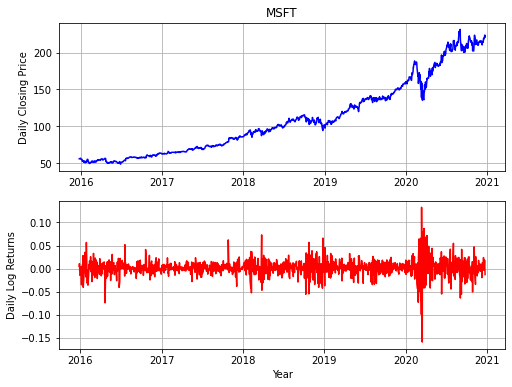

In [3]:
# Plot Closing Prices and Log Returns
fig,ax = plt.subplots(2)
ax[0].plot(dates,closing_prices,color='b')
ax[0].grid(True)
ax[0].set_ylabel('Daily Closing Price')
ax[0].set_title(security)

ax[1].plot(dates[1:],log_returns,color='r')
ax[1].grid(True)
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Daily Log Returns')

fig.set_size_inches(8,6)
plt.show()

In [4]:
# Create a Yule-Simon Time Series Object
Chain = ys.TimeSeries(log_returns)

In [5]:
# Do Inference 
nsteps = 1000
burnin = nsteps/2.0
downsample = 20
history = Chain.step(nsteps)

....................................................................................................

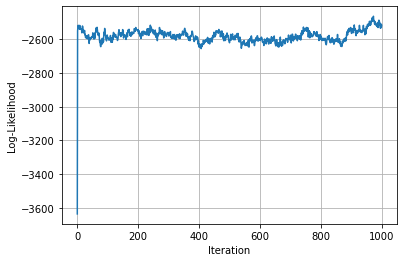

In [6]:
# Check Overall Model Convergence by Plotting the Log-Likelihood
ax3 = plt.subplot()
ax3.plot(history.log_likelihood)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Log-Likelihood')
ax3.grid(True)
plt.show()

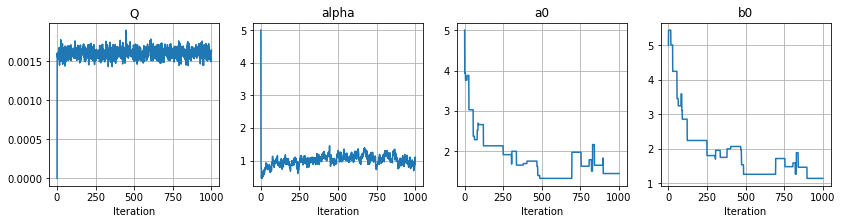

In [7]:
# Check Hyperparameter Convergence by Plotting their Posterior Samples
fig,ax = plt.subplots(1,4)
ax[0].plot(history.process_noise) 
ax[0].grid(True)
ax[0].set_title('Q')
ax[0].set_xlabel('Iteration')
ax[1].plot(history.alpha)
ax[1].grid(True)
ax[1].set_title('alpha')
ax[1].set_xlabel('Iteration')
ax[2].plot(history.hyperparameter_a0)
ax[2].grid(True)
ax[2].set_title('a0')
ax[2].set_xlabel('Iteration')
ax[3].plot(history.hyperparameter_b0)
ax[3].grid(True)
ax[3].set_title('b0')
ax[3].set_xlabel('Iteration')
fig.set_size_inches(14,3)
plt.show()

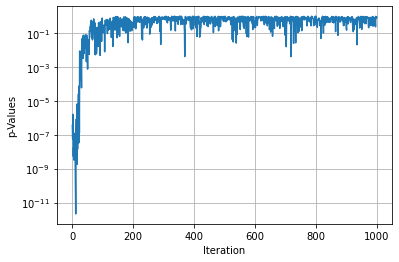

In [8]:
# Check Model Fit by Plotting p-Values
ax3 = plt.subplot()
ax3.semilogy(history.pvalue[1:])
ax3.set_xlabel('Iteration')
ax3.set_ylabel('p-Values')
ax3.grid(True)
plt.show()

In [9]:
# Compute Latent Variable Expectations
sigma_t, sample_size = ys.ExpectedValue(history.std_deviation,burnin,downsample,history.pvalue>0.2)
mu_t, sample_size = ys.ExpectedValue(history.mean,burnin,downsample,history.pvalue>0.2)

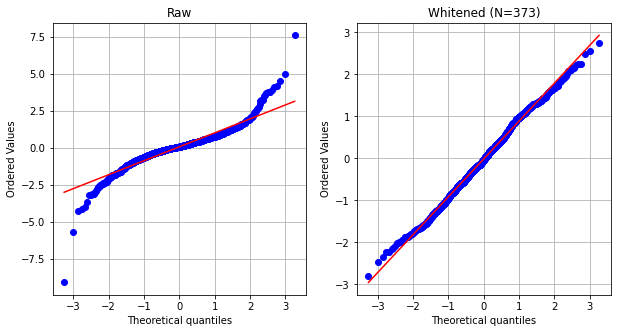

In [10]:
# Check Model Fit Against Gaussian Percentiles
fig, ax = plt.subplots(1,2)
res = probplot(log_returns/np.std(log_returns), plot=ax[0])
res = probplot((Chain.data-mu_t)/sigma_t, plot=ax[1])
ax[0].set_title('Raw')
ax[0].grid(True)
ax[1].set_title('Whitened '+'(N='+str(sample_size)+')')
ax[1].grid(True)
fig.set_size_inches(10,5)
plt.show()

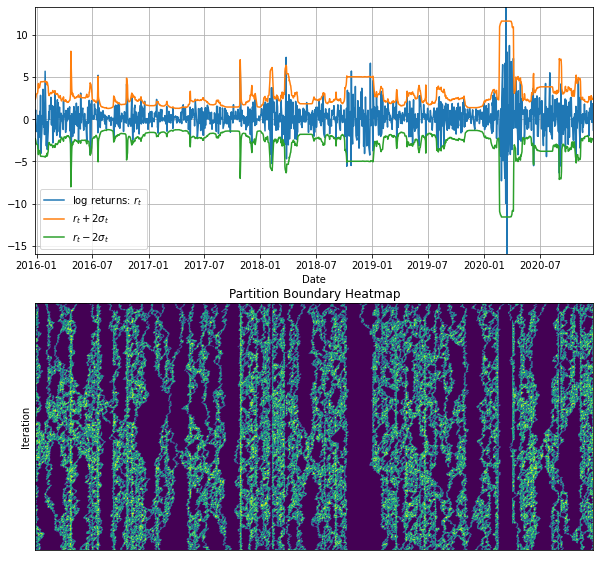

In [11]:
# Plot Latent Sigma Bounds for Measurements with Sampled Partition Boundaries
fig, ax = plt.subplots(2)
ax[0].plot(dates[1:],Chain.data,label='log returns: $r_t$')
ax[0].plot(dates[1:],+2 * sigma_t,label='$r_t+2\sigma_t$')
ax[0].plot(dates[1:],-2 * sigma_t,label='$r_t-2\sigma_t$')
ax[0].grid(True)
ax[0].autoscale(tight=True)
ax[0].set_xlabel('Date')
ax[0].legend()

ax[1].imshow(np.transpose(history.boundaries))
ax[1].set_aspect('auto')
ax[1].set_ylabel('Iteration')
ax[1].set_title('Partition Boundary Heatmap')
ax[1].set_yticks([])
ax[1].set_xticks([])
fig.set_size_inches(10,10)
plt.show()


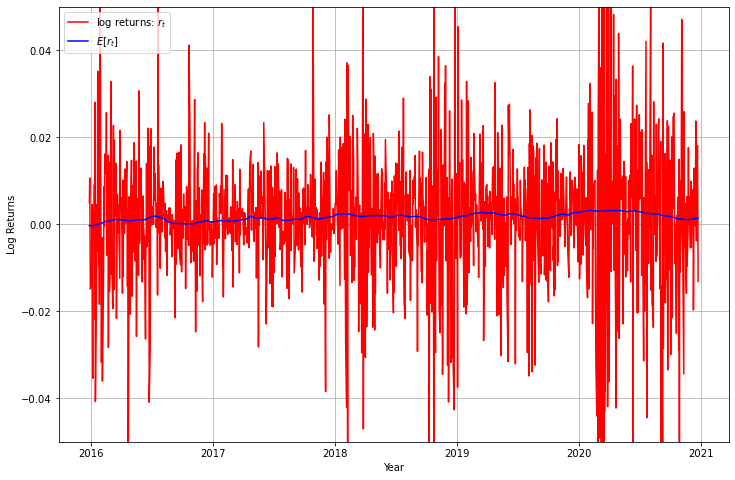

In [12]:
# Plot Average Return
fig,ax = plt.subplots()
ax.plot(dates[1:],log_returns,'r',label='log returns: $r_t$')
ax.plot(dates[1:],mu_t/100,'b',label='$E[r_t]$')
ax.grid(True)
ax.set_xlabel('Year')
ax.set_ylabel('Log Returns')
ax.set_ylim([-0.05,0.05])
fig.set_size_inches(12,8)
plt.legend()
plt.show()

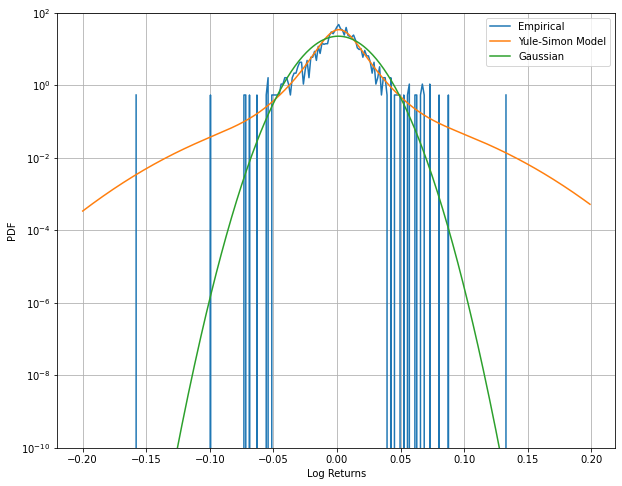

In [67]:
# Compare Yule-Simon Time Series Distribution to Empirical/Gaussian Distributions
z = np.arange(-0.2,0.2,0.001)
PDF = z*0
for ii in range(Chain.nsamp):
    PDF = PDF + ys.Gaussian(z,mu_t[ii]/100,1/((sigma_t[ii]/100)**2))
PDF = PDF/Chain.nsamp
H,b = np.histogram(log_returns,200)
delta = b[1]-b[0]
H = H/(sum(H)*delta)
bctr = b[1:]-delta/2.0

fig,ax = plt.subplots()
ax.semilogy(b[1:],H,label='Empirical')
ax.semilogy(z,PDF,label='Yule-Simon Model')
ax.semilogy(z,ys.Gaussian(z,np.mean(log_returns),1/np.var(log_returns)),label='Gaussian')
ax.grid(True)
ax.set_xlabel('Log Returns')
ax.set_ylabel('PDF')
ax.set_ylim([1e-10,1e2])
fig.set_size_inches(10,8)
plt.legend()
plt.show()

0.9978721247081235
